In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download fedesoriano/heart-failure-prediction

Dataset URL: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction
License(s): ODbL-1.0
  0% 0.00/8.56k [00:00<?, ?B/s]
100% 8.56k/8.56k [00:00<00:00, 20.6MB/s]


In [ ]:
!unzip heart-failure-prediction.zip

Archive:  heart-failure-prediction.zip
  inflating: heart.csv               


In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv("heart.csv")
data.drop(columns=["Cholesterol","FastingBS"],inplace=True)
train = data.sample(frac=0.8, random_state=0)
test = data.drop(train.index)

In [ ]:
train.shape

(734, 10)

In [ ]:
test.head()

,Age,Sex,ChestPainType,RestingBP,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
9,48,F,ATA,120,Normal,120,N,0.0,Up,0
11,58,M,ATA,136,ST,99,Y,2.0,Flat,1
19,36,M,ATA,120,Normal,160,N,3.0,Flat,1
23,44,M,ATA,150,Normal,150,Y,3.0,Flat,1
25,36,M,NAP,130,Normal,178,N,0.0,Up,0


In [ ]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

def process(data):
  columns = ["Sex","ChestPainType","RestingECG","ExerciseAngina","ST_Slope"]
  for column in columns:
    le = LabelEncoder()
    le.fit(data[column])
    data[column] = le.transform(data[column])
    print(f"{dict(zip(le.classes_,le.transform(le.classes_)))}")
  return data

train = process(train)
test = process(test)

train_x = train.drop(columns=["HeartDisease"])
train_y = train["HeartDisease"]


test_x = test.drop(columns=["HeartDisease"])
test_y = test["HeartDisease"]


{'F': 0, 'M': 1}
{'ASY': 0, 'ATA': 1, 'NAP': 2, 'TA': 3}
{'LVH': 0, 'Normal': 1, 'ST': 2}
{'N': 0, 'Y': 1}
{'Down': 0, 'Flat': 1, 'Up': 2}
{'F': 0, 'M': 1}
{'ASY': 0, 'ATA': 1, 'NAP': 2, 'TA': 3}
{'LVH': 0, 'Normal': 1, 'ST': 2}
{'N': 0, 'Y': 1}
{'Down': 0, 'Flat': 1, 'Up': 2}


In [ ]:
# {'F': 0, 'M': 1}
# {'ASY': 0, 'ATA': 1, 'NAP': 2, 'TA': 3}
# {'LVH': 0, 'Normal': 1, 'ST': 2}
# {'N': 0, 'Y': 1}
# {'Down': 0, 'Flat': 1, 'Up': 2}

In [ ]:
train.shape

(734, 10)

In [ ]:
from tensorflow.keras.utils import to_categorical
train_x = train_x.to_numpy()
test_x = test_x.to_numpy()

train_y = train_y.to_numpy().reshape((-1,1))
test_y = test_y.to_numpy().reshape((-1,1))

In [ ]:
train_x = train_x.reshape(-1,1,9)
test_x = test_x.reshape(-1,1,9)

In [ ]:
from tensorflow import keras
from tensorflow.keras import callbacks

modelCheckpoint = callbacks.ModelCheckpoint(
    "./models/model2.keras",
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
)

model = keras.Sequential(
  [  keras.layers.Input(shape=(None,9)),
    keras.layers.LSTM(128,activation="tanh", return_sequences=True),
    keras.layers.LSTM(64, activation="tanh"),
    keras.layers.Dense(1,activation="sigmoid")]
)

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy","F1Score","Precision","Recall"]
)

# add validation set
model.fit(train_x,train_y,epochs=100,batch_size=32,validation_data=(test_x,test_y),callbacks=[modelCheckpoint])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - F1Score: 0.7207 - Precision: 0.5918 - Recall: 0.9506 - accuracy: 0.5998 - loss: 0.6666 - val_F1Score: 0.6763 - val_Precision: 0.6610 - val_Recall: 0.8298 - val_accuracy: 0.6957 - val_loss: 0.6122
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - F1Score: 0.7445 - Precision: 0.7253 - Recall: 0.7694 - accuracy: 0.6906 - loss: 0.5901 - val_F1Score: 0.6763 - val_Precision: 0.6757 - val_Recall: 0.7979 - val_accuracy: 0.7011 - val_loss: 0.5783
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - F1Score: 0.7306 - Precision: 0.7306 - Recall: 0.7827 - accuracy: 0.7093 - loss: 0.5671 - val_F1Score: 0.6763 - val_Precision: 0.6754 - val_Recall: 0.8191 - val_accuracy: 0.7065 - val_loss: 0.5792
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - F1Score: 0.7259 - Precision: 0.7272 - Recall: 0.8060 - accuracy: 0.7171 - loss: 0.5635 - val_F1Score: 0.6763 - val_Precision: 0.6667 - val_Recall: 0.8085 - val_accuracy: 0.6957 - val_loss: 0.5642
E

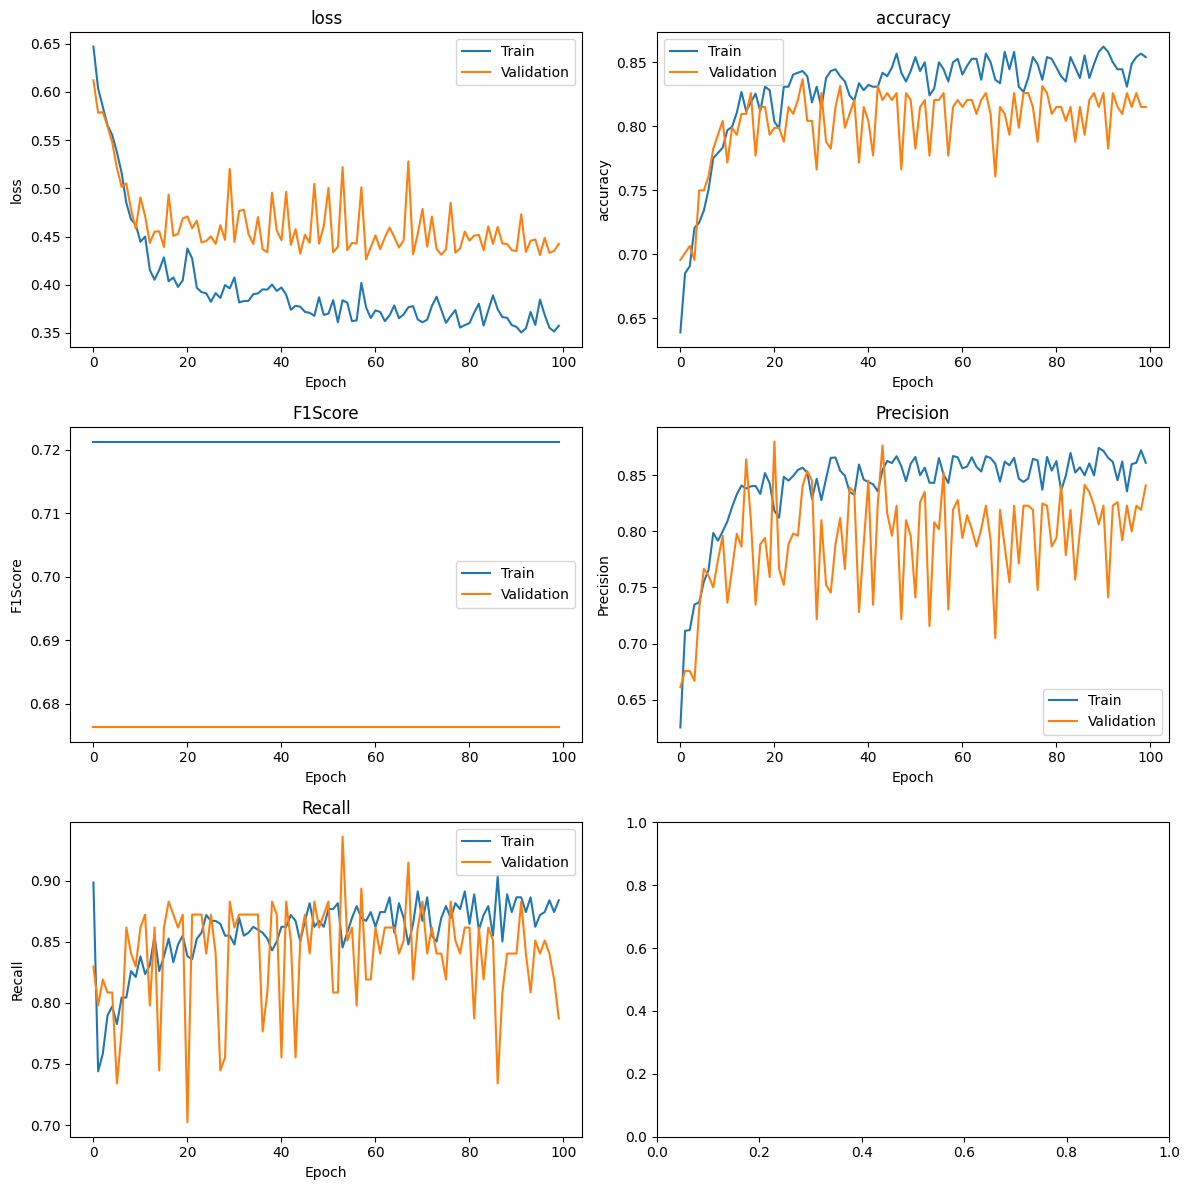

In [ ]:
import matplotlib.pyplot as plt

history = model.history

fig, ax = plt.subplots(3, 2, figsize=(12, 12))  # Added figsize for better clarity
metrics = ["loss", "accuracy", "F1Score", "Precision", "Recall"]
temp = 0

for i in range(3):
    for j in range(2):
        if temp < len(metrics):  # Check to avoid index out of range
            ax[i][j].plot(history.history[metrics[temp]])  # Plot train metrics
            ax[i][j].plot(history.history[f'val_{metrics[temp]}'])  # Plot validation metrics
            ax[i][j].set_title(f'{metrics[temp]}')  # Set title without indices
            ax[i][j].set_xlabel('Epoch')
            ax[i][j].set_ylabel(metrics[temp])  # Correct ylabel
            ax[i][j].legend(['Train', 'Validation'])
            temp += 1

plt.tight_layout()  # Adjust the layout to avoid overlap
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


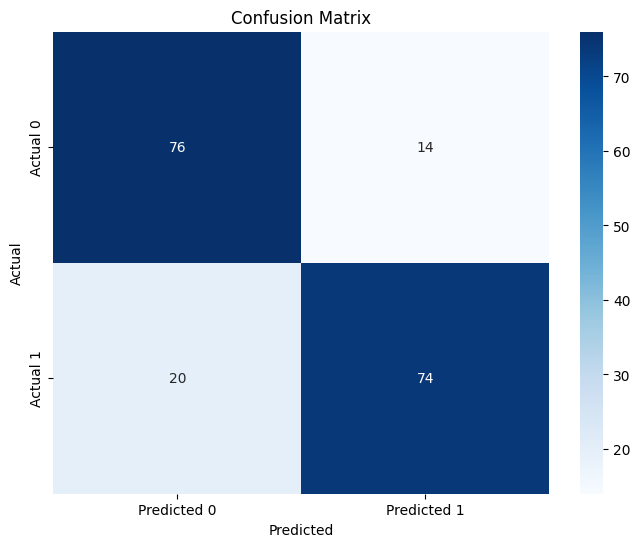

In [ ]:
# prompt: create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'model' and 'test_x', 'test_y' are defined from the previous code

y_pred = model.predict(test_x)
y_pred_classes = (y_pred > 0.5).astype(int)

conf_matrix = confusion_matrix(test_y, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
data.shape

(918, 10)

In [ ]:
model.save("./models/model2.keras")